In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, skellam, kstest
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# Load CSV data with Pandas
df_euro = pd.read_csv('scores+fixtures.csv')
# View data
df_euro.tail(5)
#print(df_euro["Round"] == "Final")
# First lets copy final to a new dataframe
df_final = df_euro[df_euro["Round"] == "Final"].copy()


In [3]:

# Now lets go ahead and remove it from our orginal dataframe
df_euro = df_euro[df_euro["Round"] != 'Final']

# Check df types
df_euro.dtypes

Round              object
Wk                float64
Day                object
Date               object
Time               object
Home               object
xG                float64
Score              object
GF                  int64
GA                  int64
PenF              float64
PenA              float64
xG.1              float64
Away               object
Attendance         object
Venue              object
Referee            object
Match Report       object
Notes              object
Referee.1          object
Match Report.1     object
dtype: object

In [4]:
# assign type int to 'Home Goals' & ' Away Goals'
df_euro = df_euro.astype({"GF": int, "GA": int})

In [5]:
print('Mean number of Goals scored per match: ', round(df_euro['GF'].mean(), 2))
print('Mean number of Goals conceeded per match: ', round(df_euro['GA'].mean(), 2))

Mean number of Goals scored per match:  1.16
Mean number of Goals conceeded per match:  1.56


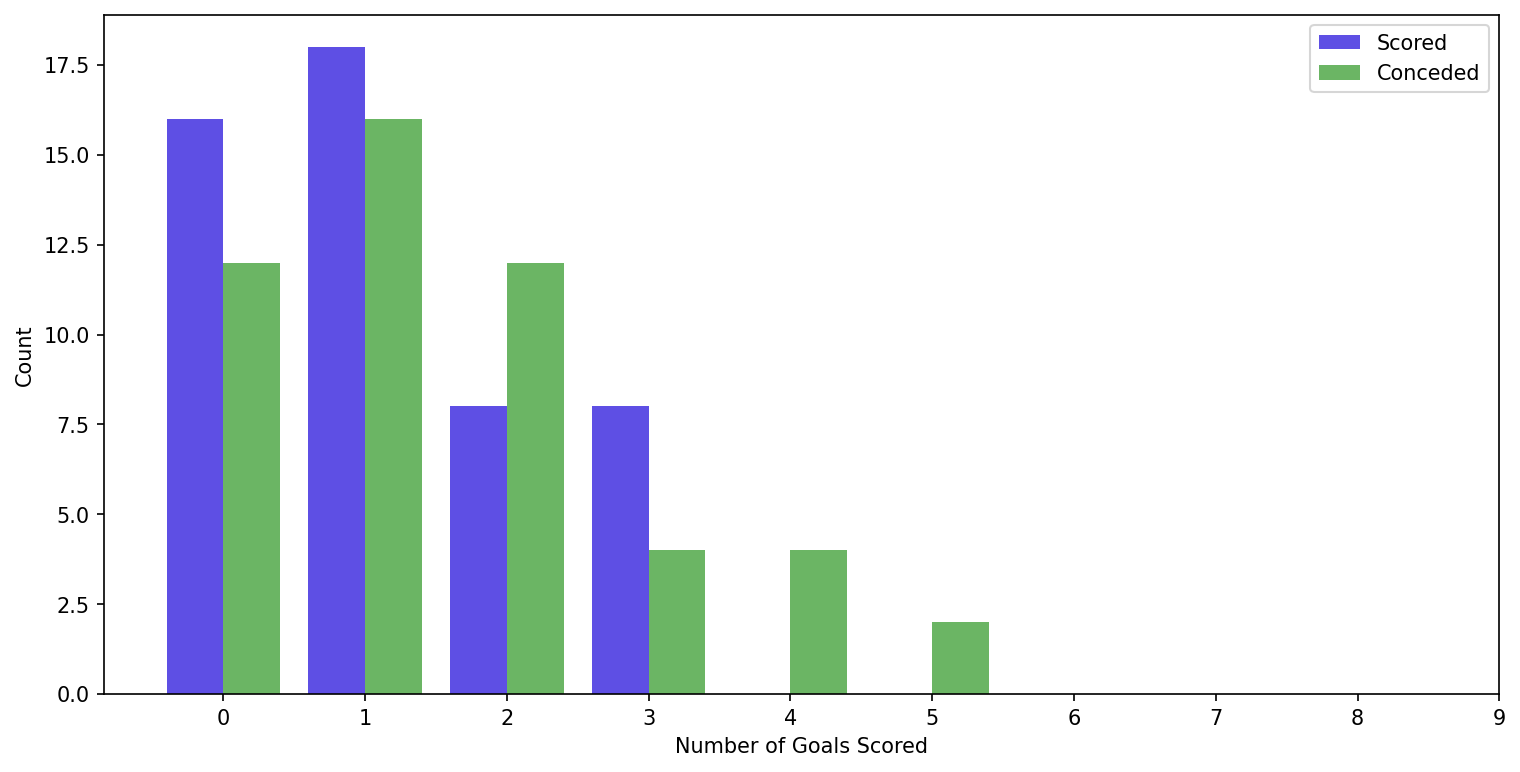

In [6]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150)

ax.hist(df_euro[['GF', 'GA']].values,
        range(10),
        alpha=0.7,
        label=['Scored', 'Conceded'],
        color=["#1a04d9", "#2c9623"])

plt.xticks([i - 0.5 for i in range(1, 11)], [i for i in range(10)])
plt.xlabel('Number of Goals Scored')
plt.ylabel('Count')
plt.legend()
plt.show()

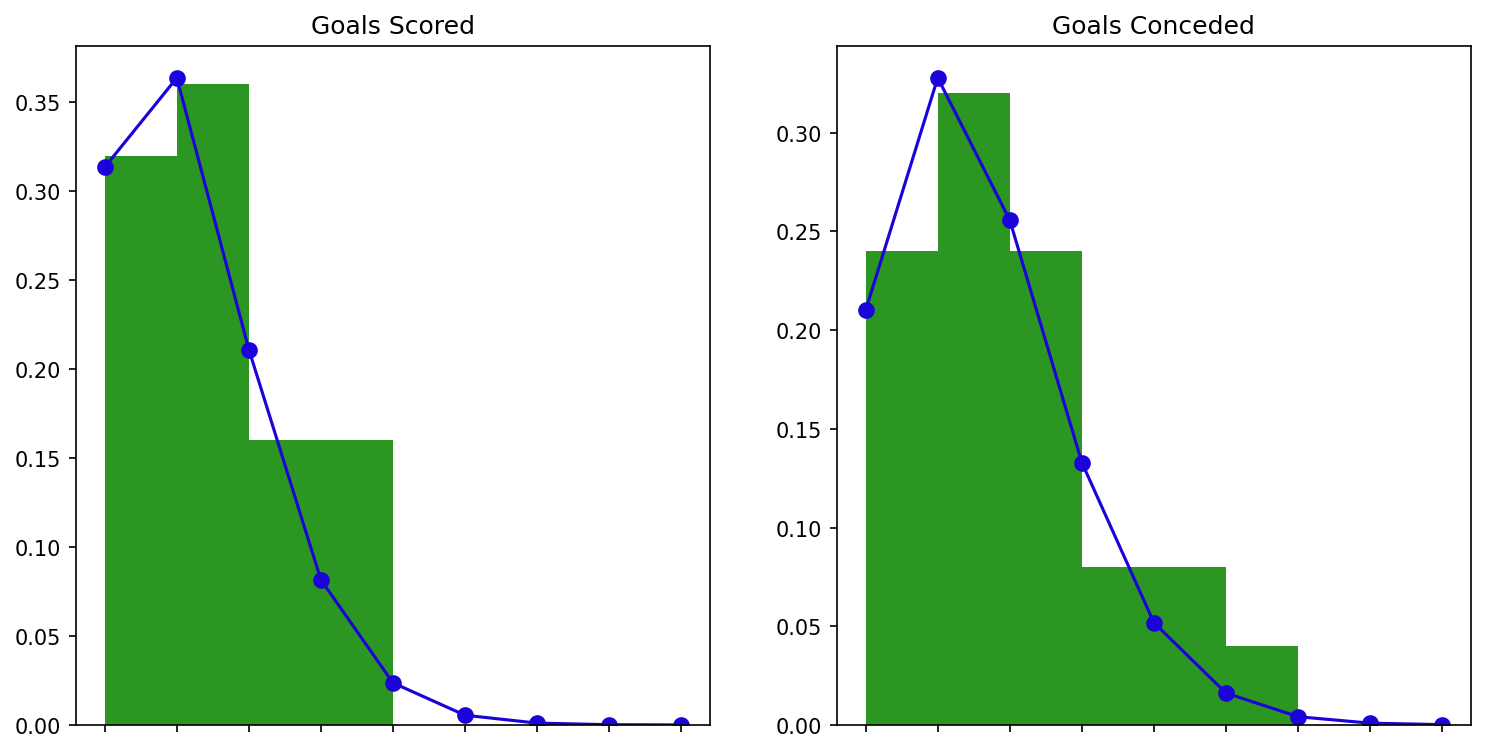

In [7]:
# Lets set mu for Home Side Goals
mu_h = df_euro['GF'].mean()
mu_a = df_euro['GA'].mean()

# Plot figs
fig, (ax1, ax2) = plt.subplots(1,
                               2,
                               sharex=False,
                               sharey=False,
                               figsize=(12, 6),
                               dpi=150)

# generate a range of data using the pmf of a Poisson distribution
x = np.arange(poisson.ppf(0.01, mu_h), poisson.ppf(0.99, mu_h))

# plot data
ax1.plot(range(9),
         poisson.pmf(range(9), mu_h),
         '-o',
         ms=7,
         label='poisson pmf',
         color="#1a04d9")

ax1.hist(df_euro['GF'].values,
         bins=range(9),
         density=True,
         color='#2c9623')

ax1.set_xticklabels('')
ax1.set_title('Goals Scored')

# generate a range of data using the pmf of a Poisson distribution
x = np.arange(poisson.ppf(0.01, mu_a), poisson.ppf(0.99, mu_a))

# plot data
ax2.plot(range(9),
         poisson.pmf(range(9), mu_a),
         '-o',
         ms=7,
         label='poisson pmf',
         color="#1a04d9")

ax2.hist(df_euro['GA'].values,
         bins=range(9),
         density=True,
         color='#2c9623')

ax2.set_title('Goals Conceded')
ax2.set_xticklabels('')

plt.show()

In [8]:
dist = poisson(df_euro[df_euro["Home"] == 'England']['GF'].mean())

print(
    'Probability of England scoring 3 or more Home Goals: ',
    round(
        dist.pmf(3) + dist.pmf(4) + dist.pmf(5) + dist.pmf(6) + dist.pmf(7) +
        dist.pmf(8) + dist.pmf(9), 2))

Probability of England scoring 3 or more Home Goals:  0.13


In [9]:
dist1 = poisson(df_euro[df_euro["Home"] == 'Italy']['GF'].mean())

print(
    'Probability of Italy scoring 3 or more Home Goals: ',
    round(
        dist1.pmf(3) + dist.pmf(4) + dist.pmf(5) + dist.pmf(6) + dist.pmf(7) +
        dist1.pmf(8) + dist.pmf(9), 2))

Probability of Italy scoring 3 or more Home Goals:  0.19


In [10]:
print('Probability of the team drawing a game:',
      round(skellam.pmf(0, mu_h, mu_a),2))

Probability of the team drawing a game: 0.25


In [11]:
eng_home = df_euro[df_euro["Home"] == 'England']["GF"].mean()
eng_away = df_euro[df_euro["Away"] == 'Italy']["GA"].mean()

match_probs = []

for k in range(4):
    for j in range(4):
        match_probs.append(['{} - {}'.format(k,j) ,poisson.pmf(k, eng_home), poisson.pmf(j, eng_away)])
        
pd.DataFrame(match_probs, columns=['Goals','England', 'Italy']).round(2)

,Goals,England,Italy
0,0 - 0,0.29,0.08
1,0 - 1,0.29,0.21
2,0 - 2,0.29,0.26
3,0 - 3,0.29,0.21
4,1 - 0,0.36,0.08
5,1 - 1,0.36,0.21
6,1 - 2,0.36,0.26
7,1 - 3,0.36,0.21
8,2 - 0,0.22,0.08
9,2 - 1,0.22,0.21


In [12]:
# Generalised Linear Model
goal_model_data = pd.concat([
    df_euro[['Home', 'Away',
            'GF']].assign(home=1).rename(columns={
                'Home': 'team',
                'Away': 'opponent',
                'GF': 'goals'
            }),
    df_euro[['Away', 'Home',
            'GA']].assign(home=0).rename(columns={
                'Away': 'team',
                'Home': 'opponent',
                'GA': 'goals'
            })
])

poisson_model = smf.glm(formula="goals ~ home + team + opponent",
                        data=goal_model_data,
                        family=sm.families.Poisson())
poisson_model= poisson_model.fit(method="lbfgs")

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  100
Model:                            GLM   Df Residuals:                       52
Model Family:                 Poisson   Df Model:                           47
Link Function:                    log   Scale:                          1.0000
Method:                         lbfgs   Log-Likelihood:                -113.97
Date:                Thu, 22 Jul 2021   Deviance:                       51.742
Time:                        16:46:25   Pearson chi2:                     41.6
No. Iterations:                    20                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.4519      0.738      0.612      0.540      -0.995       1.899
team[T.Belgium]                 1.0054      0.774      1.298      0.194      -0.512       2.523
team[T.Croatia]                 1.8877      0.782      2.414      0.016       0.355       3.420
team[T.Czech Republic]          0.3363      0.714      0.471      0.637      -1.062       1.735
team[T.Denmark]                 1.6760      0.771      2.172      0.030       0.164       3.188
team[T.England]                 0.7191      0.637      1.129      0.259      -0.530       1.968
team[T.Finland]                -0.5478      1.224     -0.448      0.654      -2.946       1.851
team[T.France]                  0.5091      0.786      0.648      0.517      -1.031       2.050
team[T.Germany]                 0.7835      0.840      0.933      0.351      -0.862       2.429
team[T.Hungary]                 0.1156      0.923      0.125      0.900      -1.694       1.925
team[T.Italy]                   0.9538      0.694      1.374      0.169      -0.407       2.314
team[T.Netherlands]             0.1036      0.641      0.162      0.871      -1.152       1.359
team[T.North Macedonia]        -0.6474      0.881     -0.734      0.463      -2.375       1.080
team[T.Poland]                  0.1955      0.832      0.235      0.814      -1.436       1.827
team[T.Portugal]                0.9465      0.816      1.160      0.246      -0.653       2.546
team[T.Russia]                  0.7110      1.011      0.703      0.482      -1.270       2.692
team[T.Scotland]               -0.7358      1.210     -0.608      0.543      -3.107       1.636
team[T.Slovakia]               -0.9389      1.023     -0.918      0.359      -2.944       1.066
team[T.Spain]                   0.3070      0.695      0.442      0.659      -1.055       1.669
team[T.Sweden]                 -0.0060      0.771     -0.008      0.994      -1.518       1.506
team[T.Switzerland]             0.9072      0.744      1.220      0.223      -0.551       2.365
team[T.Turkey]                 -0.9464      1.211     -0.782      0.434      -3.320       1.427
team[T.Ukraine]                 0.2044      0.646      0.317      0.752      -1.061       1.470
team[T.Wales]                  -0.2223      0.869     -0.256      0.798      -1.925       1.480
opponent[T.Belgium]            -1.6948      0.845     -2.005      0.045      -3.352      -0.038
opponent[T.Croatia]             0.1589      0.711      0.223      0.823      -1.235       1.553
opponent[T.Czech Republic]     -1.5342      0.800     -1.917      0.055      -3.103       0.034
opponent[T.Denmark]            -0.4076      0.753     -0.541      0.588      -1.883       1.068
opponent[T.England]            -3.2262      1.192     -2.706      0.007      -5.563      -0.889
opponent[T.

In [13]:
#teams better than England will have a higher value, while worse teams have a lower value.


# Print final predictions for the Home team
for x in range(len(df_final)):

    print(
        df_euro['Away'][x],
        poisson_model.predict(
            pd.DataFrame(data={
                'team': df_euro['Away'][x],
                'opponent': df_euro['Home'][x],
                'home': 1
            },
                         index=[1])).values)

Italy [2.36366131]


In [14]:
# Print final predictions for the Away team
for x in range(len(df_final)):

    print(
        df_final.reset_index()['Away'][x],
        poisson_model.predict(
            pd.DataFrame(data={
                'team': df_final.reset_index()['Away'][x],
                'opponent': df_final.reset_index()['Home'][x],
                'home': 1
            },
                         index=[1])).values)

Italy [0.087193]


In [16]:
poisson_model.predict(pd.DataFrame(data={'team': 'Italy', 'opponent': 'England',
                                       'home':1},index=[1]))

1    0.087193
dtype: float64

In [17]:
poisson_model.predict(pd.DataFrame(data={'team': 'England', 'opponent': 'Italy',
                                       'home':1},index=[1]))

1    0.453002
dtype: float64

In [18]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [19]:
simulate_match(poisson_model, 'England', 'Italy', max_goals=3)

array([[5.40662742e-01, 8.75645803e-02, 7.09088600e-03, 3.82808239e-04],
       [2.44921159e-01, 3.96669066e-02, 3.21218365e-03, 1.73412796e-04],
       [5.54748547e-02, 8.98458873e-03, 7.27562379e-04, 3.92781485e-05],
       [8.37673511e-03, 1.35667809e-03, 1.09862340e-04, 5.93102312e-06]])

In [22]:
#england win
eng_it = simulate_match(poisson_model, "England", "Italy", max_goals=10)
np.sum(np.tril(eng_it, -1))

0.3204485187176504

In [23]:
# draw
np.sum(np.diag(eng_it))

0.5810631690382454

In [24]:
# Italy win 
np.sum(np.triu(eng_it, 1))

0.09848831224137611